In [1]:
import os
import pickle
from tqdm.notebook import tqdm 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats import norm

#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# afinn
from afinn import Afinn 

# transformer
from transformers import pipeline

In [2]:
pd.__version__

'1.3.3'

# Sentiment score investigations
This notebook investigates the properties of two different sentiment score approaches; 1) the lexicon- and rule-based VADER approach and 2) a tranformer based approach using a pretrained BERT to model sentiment of quotes. A third score - the naïve AFINN lexicon-based approach - is also provided but is deemed to simple from the beginning and serve as a possible comparison (if wanted). 

### Initial analyses
We will start by investigating three different approaches for adding sentiment scores
to quotes. One uses the simpler dictionary-based sentiment ranking system of
the [AFINN lexicon](http://www2.imm.dtu.dk/pubdb/edoc/imm6006.pdf). Another is the [VADER sentiment module](https://github.com/cjhutto/vaderSentiment) that was used in the tutorial on text handling. This is lexicon- and rule-based and tuned to sentiments occuring in textual data from socia media and has the advantage to AFINN that it includes the negative, neutral, positive as well as the compound (combined and scaled between -1 and 1) sentiment scores of a string whereas this should be manually handled with AFINN. The last approach uses
the nowadays hyped transformers, where a pretrained transformer
from [HuggingFace](https://github.com/huggingface/transformers) determined to use the distilled BERT model that is unsenstive to the case of words (the default model). We choose to stay with the default pretrained model as the distillation makes it faster and the unsensitiveness to casing as we want to examine quotes and not online textual expressions as tweets. With the latter we mean that the casing is redundant to incorporate when dealing with spoken text compared to written text expressions - as an example the case sensitive model would be of interest to use for tweets where "FUCK" and "fuck" should definitely be related to different scores. The default model the model `distilbert-base-uncased` and we would like to refer to the [paper accompanying the model](https://arxiv.org/abs/1910.01108) for more technical details.

In general we put more weight on the VADER and Transformer approaches as they are less naïve but we keep the AFINN as an option that might be a "funny" feature for interactive plots.

In [3]:
#!pip install Afinn
#!pip install transformers[sentencepiece]

In [4]:
afn = Afinn()

In [5]:
vaderAnalyzer = SentimentIntensityAnalyzer()

In [6]:
classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


We initially test the approaches on a couple of examples to get an idea of how and whether they work or not. A helper function for the AFINN and VADER objects is used for similar output as the transformer.

In [7]:
def output_aux(score, threshold=0):
    """Helper function for outputting similar output as the transformer."""
    
    if score < threshold:
        prediction_dict = [{'label': 'NEGATIVE', 'score': score}]
    else:
        prediction_dict = [{'label': 'POSITIVE', 'score': score}]
        
    return prediction_dict

In [8]:
negative_sentence = "Fuck you fucking dumb BERT model, you dumbass"
print(f'"{negative_sentence}":\n Transformer: \t {classifier(negative_sentence)}\n AFINN:\t\t {output_aux(afn.score(negative_sentence))}\n VADER: \t {output_aux(vaderAnalyzer.polarity_scores(negative_sentence)["compound"])}\n')

positive_sentence = "I love my ADA group - they're the best! <3"
print(f'"{positive_sentence}":\n Transformer: \t {classifier(positive_sentence)}\n AFINN:\t\t {output_aux(afn.score(positive_sentence))}\n VADER: \t {output_aux(vaderAnalyzer.polarity_scores(positive_sentence)["compound"])}\n')

"Fuck you fucking dumb BERT model, you dumbass":
 Transformer: 	 [{'label': 'NEGATIVE', 'score': 0.9992602467536926}]
 AFINN:		 [{'label': 'NEGATIVE', 'score': -14.0}]
 VADER: 	 [{'label': 'NEGATIVE', 'score': -0.8932}]

"I love my ADA group - they're the best! <3":
 Transformer: 	 [{'label': 'POSITIVE', 'score': 0.9998805522918701}]
 AFINN:		 [{'label': 'POSITIVE', 'score': 6.0}]
 VADER: 	 [{'label': 'POSITIVE', 'score': 0.9117}]



Based on this single (however super representative!!!) example we see that all three approaches work but that the output scores are quite differently scaled. This is due to the fact that the transformer has a softmax layer in the end and therefore outputs the probability of the most probable label - which is either "POSITIVE" or "NEGATIVE". On the other hand AFINN accumulates a the score of both positive and negative words to get a single score. The AFINN score can thus strongly depend on the length of a sentence and we would need to introduce a normalization term. The VADER scores are as mentioned pre-scaled and normalized in the range between -1 and 1 in the module implementation.

In [9]:
symbols = ['<3', ':-)', ':-(']

for sym in symbols:
    print(f'"{sym}":\n Transformer: \t {classifier(sym)}\n AFINN:\t\t {output_aux(afn.score(sym))}\n VADER: \t {output_aux(vaderAnalyzer.polarity_scores(sym)["compound"])}\n')

"<3":
 Transformer: 	 [{'label': 'POSITIVE', 'score': 0.979346513748169}]
 AFINN:		 [{'label': 'POSITIVE', 'score': 0.0}]
 VADER: 	 [{'label': 'POSITIVE', 'score': 0.4404}]

":-)":
 Transformer: 	 [{'label': 'POSITIVE', 'score': 0.5607805848121643}]
 AFINN:		 [{'label': 'POSITIVE', 'score': 0.0}]
 VADER: 	 [{'label': 'POSITIVE', 'score': 0.3182}]

":-(":
 Transformer: 	 [{'label': 'NEGATIVE', 'score': 0.87599778175354}]
 AFINN:		 [{'label': 'POSITIVE', 'score': 0.0}]
 VADER: 	 [{'label': 'NEGATIVE', 'score': -0.3612}]



As seen above some of the approaches differ when examining symbols like smileys and hearts. Here, the manually defined AFINN lexicon can not encounter such tokens, where the transformer on the contrary has learned to encounter these and in fact do quite a good job (except for the 'positive' smiley). The rule-based lexicon of VADER has indeed also learned the mapping of such smileys and symbols. Even though symbols like these are not immediately associated with quotes - as quotes are text capturing spoken language - it might come in as a good feature that the transformer and the VADER approaches are more complex and understand the local sentiment of subtokens better than AFINN. We therefore already disregard AFINN as the better approach but keep it as a possible feature for interactive plots as previously mentioned. We will investigate the other two a bit more and apply all three scores to a new dataframe.

### Applying sentiment scores to the data (skipable)
This section can be skipped if it has previously been executed!

First, we load the data that was previously processed. The pickled file was created with pandas 1.3.3. and has to be loaded with the same pandas version.

In [10]:
# Specifying filename and directory
data_dir = os.getcwd() + os.sep + 'data'
filepath = rf"{data_dir}{os.sep}Quotebank_processed.pkl"

df = pd.read_pickle(filepath)
df.head()

,quotation,speaker,qids,date,numOccurrences,probas,urls,movie,shared_ID
0,Is Ferguson like Mockingjay?,Laci Green,[Q16843606],2015-11-15,1,"[[Laci Green, 0.9013], [None, 0.0987]]",[http://www.dailykos.com/story/2015/11/15/1450...,The Hunger Games: Mockingjay - Part 2,1751
1,I want to clarify my interview on the `Charlie...,George Lucas,"[Q38222, Q1507803]",2015-12-31,7,"[[George Lucas, 0.5327], [None, 0.4248], [Char...",[http://www.escapistmagazine.com/news/view/165...,Star Wars: Episode VII - The Force Awakens,6724
2,Is Daredevil joining the Avengers for Infinity...,Scott Davis,"[Q1373440, Q7436227, Q7436228, Q7436226, Q1619...",2015-12-10,2,"[[None, 0.4806], [Scott Davis, 0.4017], [Antho...",[http://www.flickeringmyth.com/2015/12/is-dare...,Avengers: Age of Ultron,692
3,"They were saying, `Well, since when has Star W...",J.J. Abrams,[Q188137],2015-12-21,1,"[[J.J. Abrams, 0.5868], [None, 0.2584], [Lupit...",[http://rssfeeds.usatoday.com/~/129385923/0/us...,Star Wars: Episode VII - The Force Awakens,2394
4,You meet new characters and you learn about Ha...,Kevin Feige,[Q515161],2015-05-06,1,"[[Kevin Feige, 0.9108], [None, 0.0782], [Scott...",[http://www.digitaltrends.com/movies/ant-man-m...,Avengers: Age of Ultron,8789


Now we compute the sentiment scores with AFINN score, VADER score and the BERT transformer based score. We do two things here; first we redefine the auxiliary function used to change the output format such that it normalizes the sentiment by the length of a quote (defined by number of words splitted at whitespaces) when using AFINN and second we are aware that the transformer is limited to a certain input sequence length and add a NaN-value for a quote if it is longer than this maximum sequence length. Later we will try to scale the different scores such that they are comparable.

In [11]:
def afn_aux(quote):
    """Helper function for outputting similar output as the transformer."""
    
    score = afn.score(quote) / len(quote.split(" "))

    if score < 0:
        prediction_dict = [{'label': 'NEGATIVE', 'score': score}]
    else:
        prediction_dict = [{'label': 'POSITIVE', 'score': score}]
        
    return prediction_dict

In [12]:
sentiments_AFINN = [afn_aux(quote) for quote in tqdm(df.quotation)]

  0%|          | 0/70297 [00:00<?, ?it/s]

In [13]:
sentiments_VADER = [output_aux(vaderAnalyzer.polarity_scores(quote)['compound']) for quote in tqdm(df.quotation)]

  0%|          | 0/70297 [00:00<?, ?it/s]

In [14]:
# the model is limited to handling sequences of a prespecified length.
# We handle this by using the try-except statement and add a nan-value where the 
# BERT can't handle the input quote.
sentiments_BERT = []
for quote in tqdm(df.quotation):
    try:
        BERT_score = classifier(quote)
        sentiments_BERT.append(BERT_score)
    except RuntimeError:
        sentiments_BERT.append(np.nan)

  0%|          | 0/70297 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (523 > 512). Running this sequence through the model will result in indexing errors


We temporarily add the sentiment scores to the dataframe for easier removing the NaN values that might occur in the BERT sentiment scores.

In [15]:
df['sentiments_AFINN'] = sentiments_AFINN
df['sentiments_VADER'] = sentiments_VADER
df['sentiments_BERT'] = sentiments_BERT

We check how many NaN values we created by use of the transformer and remove them. The justification for this is mainly that we do not have time for training a new model and prefer using a pretrained one that has already shown a prominent performance and that it seems plausible that (super) long quotes are erroneous data that has not been removed in the Quotebank approach of scraping the quotes from newspaper articles. Below we print out 3 random of the 88 quotes that were too long for the transformer to handle.

In [16]:
print(f"Number of NaN-values in BERT sentiment score: {df.isnull().any(axis=1).sum()}")

Number of NaN-values in BERT sentiment score: 117


In [17]:
NaN_quotes = df[df.isnull().any(axis=1)]

random_ids = np.random.randint(0, len(NaN_quotes), size=3)
for random_id in random_ids:
    print(f"{NaN_quotes.quotation.iloc[random_id]}\n")

As a matter of fact I do. „ ~ Fred Jones after Daphne ask him if he has anymore ideas in A Pup Named Scooby-Doo Trivia Edit Freddie Prinze Jr, doesn't think very fondly of the Scooby Doo film. Among other things, he hated wearing Fred's ascot. Prinze also had to shave his head after filming because the blond dye ruined his hair In the 2006 movie Scooby-Doo Pirates Ahoy Freddie's real parents are Skip Jones and Peggy Jones. But in the 2010-2013 television series Mystery Incorporated Fred Jones Jr. is not his real name and is adopted by Fred Jones Sr. his parents are Judy Reeves and Brad Chiles. Which means that Mystery Incorporated does not tie in with the other Scooby-Doo cartoons, series and movies. Navigation Edit Scooby-Doo Heroes Mystery Inc.. Scooby-Doo | Shaggy Rogers | Fred Jones | Daphne Blake | Velma Dinkley Secondary Characters Scrappy-Doo | Scooby-Dum | Yabba-Doo | Deputy Dusty | Flim Flam | Vincent Van Ghoul | Blue Falcon | Dynomutt Hex Girls Thorn | Dusk | Luna Ghoul Schoo

In [18]:
df = df.loc[-df.isnull().any(axis=1)]
df.index = np.arange(len(df))

df.isnull().any()

quotation           False
speaker             False
qids                False
date                False
numOccurrences      False
probas              False
urls                False
movie               False
shared_ID           False
sentiments_AFINN    False
sentiments_VADER    False
sentiments_BERT     False
dtype: bool

After having removed the NaNs, we now extract the label and score from the sentiment scores dictionaries and create individual attributes for these for each sentiment approach. This is done for easier access in future tasks.

In [19]:
AFINN_label, AFINN_score = [], []
VADER_label, VADER_score = [], []
BERT_label, BERT_score = [], []

for i in tqdm(range(len(df))):
    label, score = df.sentiments_AFINN[i][0].values()
    AFINN_label.append(label), AFINN_score.append(score)
    
    label, score = df.sentiments_VADER[i][0].values()
    VADER_label.append(label), VADER_score.append(score)
    
    label, score = df.sentiments_BERT[i][0].values()
    BERT_label.append(label), BERT_score.append(score)
    

# update sentiment attributes
df['AFINN_label'] = AFINN_label
df['AFINN_score'] = AFINN_score
df['VADER_label'] = VADER_label
df['VADER_score'] = VADER_score
df['BERT_label'] = BERT_label
df['BERT_score'] = BERT_score

# remove attributes with dictionary structure
df = df.drop(['sentiments_AFINN', 'sentiments_VADER', 'sentiments_BERT'], axis=1)
df.head()

  0%|          | 0/70180 [00:00<?, ?it/s]

,quotation,speaker,qids,date,numOccurrences,probas,urls,movie,shared_ID,AFINN_label,AFINN_score,VADER_label,VADER_score,BERT_label,BERT_score
0,Is Ferguson like Mockingjay?,Laci Green,[Q16843606],2015-11-15,1,"[[Laci Green, 0.9013], [None, 0.0987]]",[http://www.dailykos.com/story/2015/11/15/1450...,The Hunger Games: Mockingjay - Part 2,1751,POSITIVE,0.500000,POSITIVE,0.3612,NEGATIVE,0.989802
1,I want to clarify my interview on the `Charlie...,George Lucas,"[Q38222, Q1507803]",2015-12-31,7,"[[George Lucas, 0.5327], [None, 0.4248], [Char...",[http://www.escapistmagazine.com/news/view/165...,Star Wars: Episode VII - The Force Awakens,6724,POSITIVE,0.165563,POSITIVE,0.9910,POSITIVE,0.999293
2,Is Daredevil joining the Avengers for Infinity...,Scott Davis,"[Q1373440, Q7436227, Q7436228, Q7436226, Q1619...",2015-12-10,2,"[[None, 0.4806], [Scott Davis, 0.4017], [Antho...",[http://www.flickeringmyth.com/2015/12/is-dare...,Avengers: Age of Ultron,692,NEGATIVE,-0.153846,NEGATIVE,-0.6369,NEGATIVE,0.833872
3,"They were saying, `Well, since when has Star W...",J.J. Abrams,[Q188137],2015-12-21,1,"[[J.J. Abrams, 0.5868], [None, 0.2584], [Lupit...",[http://rssfeeds.usatoday.com/~/129385923/0/us...,Star Wars: Episode VII - The Force Awakens,2394,POSITIVE,0.000000,NEGATIVE,-0.3612,NEGATIVE,0.991336
4,You meet new characters and you learn about Ha...,Kevin Feige,[Q515161],2015-05-06,1,"[[Kevin Feige, 0.9108], [None, 0.0782], [Scott...",[http://www.digitaltrends.com/movies/ant-man-m...,Avengers: Age of Ultron,8789,NEGATIVE,-0.011111,POSITIVE,0.1901,POSITIVE,0.999218


### Investigating the sentiment attributes (specific)

We now want to investigate the distribution of the sentiment scores for each of the approaches. We will invest all of the three but with an emphasis on VADER and the Transformer-based approach. We start by extracting the scores and label from the dictionary structure that the scores are stored and vizualising the distribution of the BERT and VADER sentiments before re-scaling them.

In [20]:
# Extracting sentiment scores and labels from the 
VADER_scores = df.VADER_score
VADER_labels = df.VADER_label

BERT_scores = df.BERT_score 
BERT_labels = df.BERT_label 

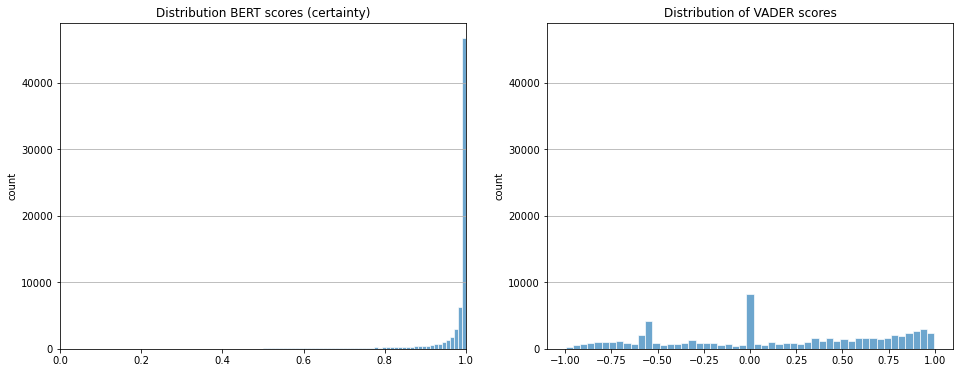

In [21]:
plt.figure(figsize=(16,6))

ax1 = plt.subplot(121)
BERT_scores.hist(edgecolor='white', linewidth=1, bins=51, alpha=0.65)
ax1.set_xlim(0,1)
ax1.set_ylabel("count")
ax1.xaxis.grid(False)
ax1.set_title("Distribution BERT scores (certainty)")

ax2 = plt.subplot(122, sharey=ax1)
VADER_scores.hist(edgecolor='white', linewidth=1, bins=51, alpha=0.65)
ax2.set_ylabel("count")
ax2.xaxis.grid(False)
ax2.set_title("Distribution of VADER scores")

plt.show()

From these plots we make some interesting explorations: as the BERT scores are softmax outputs we see that the BERT is extremely certain in it's predictions, meaning that the model tends to be more than 90-95% percent certain that the label it is predicting is correct. Furthermore, we are confirmed that we need to change the score for the BERT predictions such that it distinguishes negative from positive scores if it is to be compared with the VADER scores. On the other hand when we look at the VADER scores, it is clearly seen that the sentiment is pretty evenly distributed with exceptions around -0.5 and 0. The spike at 0 reveals that the VADER scores contain additional properties than the BERT, as it can be used to label a sentence neutral.

To deal with the issues of the BERT scores we start by expressing all the scores as the models probability of labelling the given score as "POSITIVE". In this way the scores are probabilities of the POSITIVE class that can take values from 0 to 1.

In [22]:
# change the negative labels as probability of being positive
df['positive_BERT_score'] = df.BERT_score
df.loc[df.BERT_label == 'NEGATIVE', 'positive_BERT_score'] = 1 - BERT_scores[BERT_labels == 'NEGATIVE'] #[output_aux(score, threshold=0.5) for score in BERT_scores]

posBERT_scores = df['positive_BERT_score']

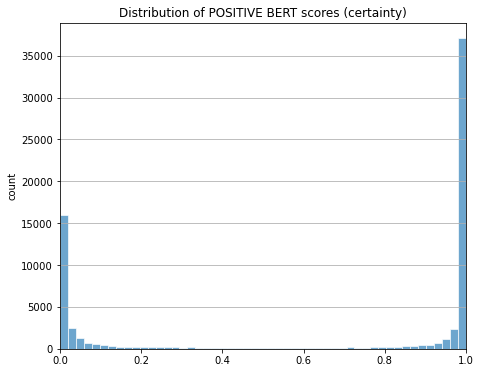

In [23]:
plt.figure(figsize=(16,6))

ax1 = plt.subplot(121)
posBERT_scores.hist(edgecolor='white', linewidth=1, bins=51, alpha=0.65)
ax1.set_xlim(0,1)
ax1.set_ylabel("count")
ax1.set_title("Distribution of POSITIVE BERT scores (certainty)")
ax1.xaxis.grid(False)
plt.show()

What seems to be the situation for the BERT scores is that there are more POSITIVE labels that the BERT is super certain about. Before investigating the relation between positive and negative labelled classes we want to rescale the BERT scores to the same scale as the VADER scores, such that they are comparable. Since the BERT scores are outputs of a softmax which generalizes to the sigmoid in the binary case (which we have here) we revert the BERT scores (reverted sigmoid) and scale them to the range -1 to 1.

In [24]:
revertedBERT = np.log(posBERT_scores / (1-posBERT_scores))

In [25]:
df['scaledReverted_BERT_score'] = 2*(revertedBERT-np.min(revertedBERT)) / (np.max(revertedBERT) - np.min(revertedBERT)) - 1
scaledRevertedBERT = df['scaledReverted_BERT_score']

We now have all sentiment scores we are interested in and save them in a pickle.

In [26]:
# Save loaded DataFrame as pickle for faster loading time in the future
filename = f"Quotebank_sentiment"
df.to_pickle(rf"{data_dir}{os.sep}{filename}.pkl")

print(f"Dataframe was pickled and saved to directory:\n{data_dir} \n")
print(f"Shape of dataframe: {df.shape}")

Dataframe was pickled and saved to directory:
C:\Users\Albert Kjøller\Documents\EPFL\Courses\CS-401_ADA\ada-2021-project-f-jab\exploratory\data 

Shape of dataframe: (70180, 17)


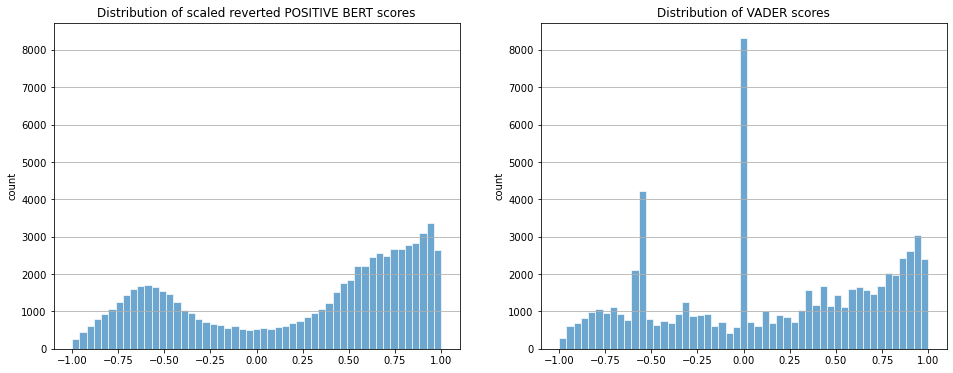

In [27]:
plt.figure(figsize=(16,6))

ax1 = plt.subplot(121)
scaledRevertedBERT.hist(edgecolor='white', linewidth=1, bins=51, alpha=0.65)
ax1.set_ylabel("count")
ax1.xaxis.grid(False)
ax1.set_title("Distribution of scaled reverted POSITIVE BERT scores")

ax2 = plt.subplot(122, sharey=ax1)
VADER_scores.hist(edgecolor='white', linewidth=1, bins=51, alpha=0.65)
ax2.set_ylabel("count")
ax2.xaxis.grid(False)
ax2.set_title("Distribution of VADER scores")

plt.show()

So we see that the scores are now comparable and actually look somewhat similar. We still see that very few of the BERT scores are classified as neutral and tend to have the density in a negative and a positive cluster. The two approaches sentiment prediction especially resemble eachother when comparing with the normalized AFINN score in the plot below. We do not scale this to a range of -1 to 1 as it seems to be normally distributed and would therefore be heavily influenced by outliers.

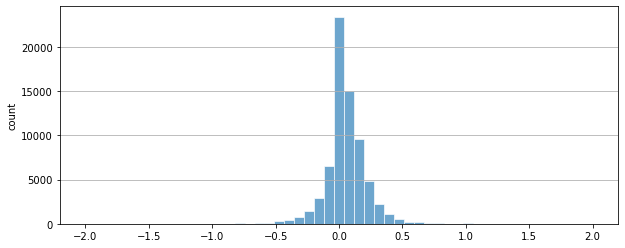

In [28]:
AFINN_scores = df.AFINN_score 
AFINN_labels = df.AFINN_label

plt.figure(figsize=(10,4))

ax = plt.subplot(111)
AFINN_scores.hist(edgecolor='white', linewidth=1, bins=51, alpha=0.65)
ax.xaxis.grid(False)
ax.set_ylabel('count')

plt.show()

We now want to examining the mean scores and distribution of labels across the classes "POSITIVE" and "NEGATIVE" to get a sense of how each approach characterizes the quotes. In the below plot we visualize the mean sentiment scores for each approach with a 95% confidence interval as well as the distribution of POSITIVE vs. NEGATIVE labels categorized by each approach. Be aware that the AFINN scores do not make sense to directly compare to the other ones in regards to the continuous score as it is on a different scale, for which reason it is left out.

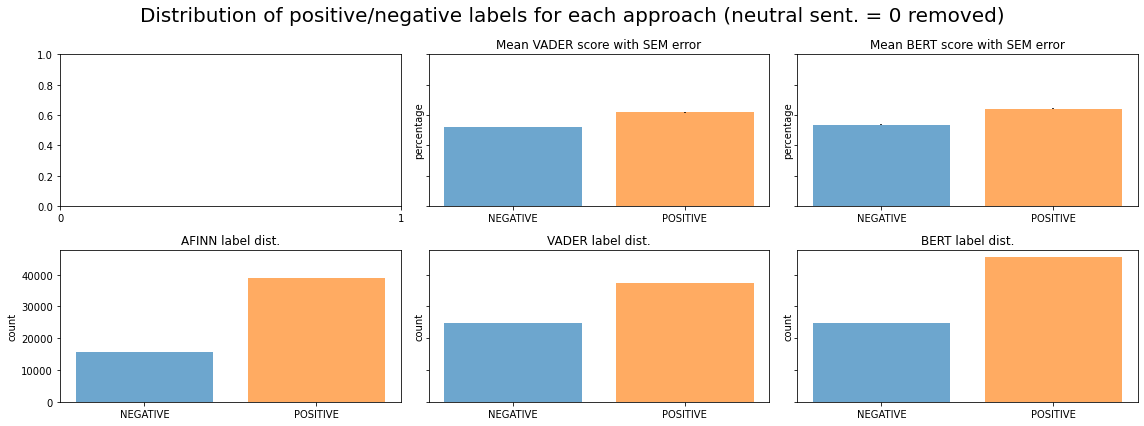

In [29]:
fig, ax = plt.subplots(2,3, figsize=(16,6),sharey='row')

attributes = ["AFINN", "VADER", "BERT"]
x = [0,1]    

for i, att in enumerate(attributes):
    if att == 'BERT':
        sent_scores = df[f'scaledReverted_BERT_score']
    else:
        sent_scores = df[f'{att}_score']

    sent_labels = df[f'{att}_label'] 
    ids_without_neutral = -np.logical_and(sent_labels=="POSITIVE", sent_scores==0)
    
    labels, counts = np.unique(sent_labels[ids_without_neutral], return_counts=True)
    temp = pd.DataFrame({'score': sent_scores[ids_without_neutral], 'labels': sent_labels[ids_without_neutral]})
    classes = temp.groupby(by='labels')
    
    err = (1.96*classes.std()/np.sqrt(sum(counts))).T.to_numpy()[0]
    
    ax[0, i].set_xticks(x)       
    if i != 0:
        ax[0, i].bar(x, abs(classes.mean().T.to_numpy()[0]), yerr=abs(err), color=['C0', 'C1'], alpha=0.65)
        ax[0, i].set_xticklabels(labels)
        ax[0, i].set_title(f"Mean {att} score with SEM error")
        ax[0, i].set_ylim(0,1)
        ax[0, i].xaxis.grid(False)     
        ax[0, i].set_ylabel("percentage")
        
    ax[1, i].bar(x, counts, color=['C0', 'C1'], alpha=0.65)
    ax[1, i].set_xticks(x)
    ax[1, i].set_xticklabels(labels)
    ax[1, i].set_title(f"{att} label dist.")
    ax[1, i].xaxis.grid(False)
    ax[1, i].set_ylabel("count")


plt.suptitle("Distribution of positive/negative labels for each approach (neutral sent. = 0 removed)", fontsize=20)
plt.tight_layout()
plt.show()

The first row of the above subplot reveals that the scores obtained with VADER and BERT are similar. The second row reveals that there is an overweight of the POSITIVE label no matter which approach is used - also when the sentiment scores equal to 0 are removed. Furthermore, this reveals the first thing about the sentiment of quotes about movies - namely that there is a slight overweigth of positively associated quotes. Lets investigate the labels of one approach when conditioning on the other (between VADER and BERT).

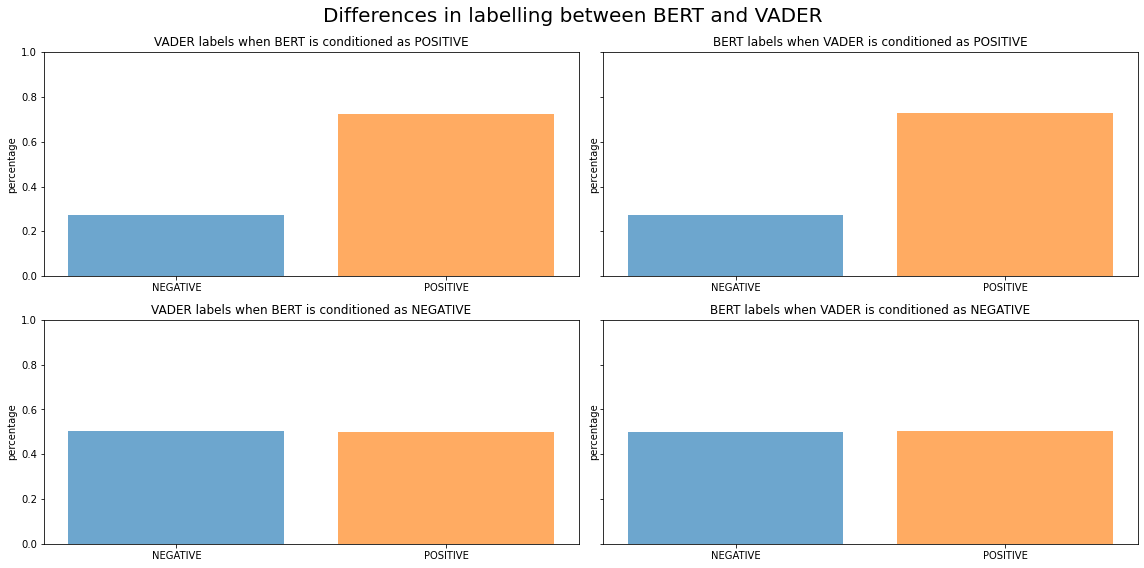

In [30]:
fig, ax = plt.subplots(2, 2, figsize=((16,8)), sharey=True)
x = [0, 1]

helper_dict = {"sent1": [(VADER_labels, "VADER"), (VADER_labels, "VADER"), (BERT_labels, "BERT"), (BERT_labels, "BERT")], 
              "sent2": [(BERT_labels, "BERT"), (BERT_labels, "BERT"), (VADER_labels, "VADER"), (VADER_labels, "VADER")],
              "category": ["POSITIVE", "NEGATIVE", "POSITIVE", "NEGATIVE"]}

for i in range(4):
    data = helper_dict["sent1"][i][0][helper_dict["sent2"][i][0] == helper_dict["category"][i]]
    labels, counts = np.unique(data, return_counts=True)
    

    ax[i%2, i//2].bar(x, counts/np.sum(counts), color=['C0', 'C1'], alpha=0.65)
    ax[i%2, i//2].set_xticks(x)
    ax[i%2, i//2].set_xticklabels(labels)
    ax[i%2, i//2].set_ylim(0, 1)    
    ax[i%2, i//2].set_title(f"{helper_dict['sent1'][i][1]} labels when {helper_dict['sent2'][i][1]} is conditioned as {helper_dict['category'][i]}")
    ax[i%2, i//2].set_ylabel("percentage")
        
plt.suptitle("Differences in labelling between BERT and VADER", fontsize=20)
plt.tight_layout()
plt.show()

As we see on the first row of the above subplots the two approaches seem to agree in around 80% of the cases for both approaches when conditioning on the POSITIVE classifications from the other approach. Contrarily we see that both approaches do not agree as much on the NEGATIVE class - in fact there are even more POSITIVE labels using the VADER approach compared to the NEGATIVE labels when we condition and use the quotes from labelled as NEGATIVE by the transformer. We can get a sence of why this is the case when conditioning on the scores of the VADER approach. We investigate this in two manners; 1) by a comparative plot, and 2) by looking at concrete quotes when the labelling from BERT and VADER differ.

In [31]:
from matplotlib.colors import to_rgb

def plotWithCondition(df, conditional_attribute, second_attribute, cond_bound=(-1,1), BERT_bound=(0, 1), movie=None):
        
    if movie != None:
        movie_slice = (df.movie == movie)    
        posBERT_scores = df[f'{second_attribute}_score'][movie_slice] #pd.Series([score_dict[0]['score'] for score_dict in df[second_attribute]])[movie_slice]
        scaledRevertedBERT = df['scaledReverted_BERT_score'][movie_slice] #pd.Series([score_dict[0]['score'] for score_dict in df['scaledReverted_BERT']])[movie_slice]   
        cond_scores = df[f'{conditional_attribute}_score'][movie_slice] #pd.Series([score_dict[0]['score'] for score_dict in df[conditional_attribute]])[movie_slice]
        movie_title = movie

    else:
        posBERT_scores = df[f'{second_attribute}_score']# pd.Series([score_dict[0]['score'] for score_dict in df[second_attribute]])
        scaledRevertedBERT = df['scaledReverted_BERT_score']#pd.Series([score_dict[0]['score'] for score_dict in df['scaledReverted_BERT']])   
        cond_scores = df[f'{conditional_attribute}_score']#pd.Series([score_dict[0]['score'] for score_dict in df[conditional_attribute]])
        movie_title = "All movies"
    
    condition = np.logical_and(cond_scores >= cond_bound[0], cond_scores < cond_bound[1])
    cond_name = conditional_attribute
    second_name = second_attribute
    
    fig = plt.figure(figsize=(16,6))
    fig.suptitle(f"\"{movie_title}\" ", fontsize=20)

    # plot of conditional attribute (VADER)
    ax1 = plt.subplot(221)
    _, bins, patches = ax1.hist(cond_scores, edgecolor='white', linewidth=1, bins=51, alpha=0.65, density=True)
    ax1.set_title(f"Distribution of {cond_name} scores \n Condition (orange) = [{cond_bound[0], cond_bound[1]}]")
    ax1.set_ylabel('density', fontsize=12)
    
    bins_lower = np.where(bins >= cond_bound[0] - 0.02)[0]
    bins_upper = np.where(bins <= cond_bound[1])[0]
    
    idxs = np.intersect1d(bins_lower, bins_upper)
    for idx in idxs[:-1]:
        patches[idx].set_facecolor('C1')
      
    # BERT probability of positive label plot
    ax2 = plt.subplot(122)
    _, bins, patches = ax2.hist(posBERT_scores[condition], edgecolor='white', linewidth=1, bins=51, alpha=0.65, density=True)
    ax2.set_title(f"BERT density of positive label")
    ax2.set_ylabel('density', fontsize=14)    

    # plot of scaled and reverted BERT scores
    ax3 = plt.subplot(223, sharex=ax1)
    _, bins, patches = ax3.hist(scaledRevertedBERT[condition], edgecolor='white', linewidth=1, bins=51, alpha=0.65, density=True)
    ax3.set_title(f"Scaled, reverted {second_name} scores \n Condition (lightblue) = [{BERT_bound[0], BERT_bound[1]}]")
    ax3.set_ylabel('density', fontsize=12)
    ax3.set_xlim(-1.1,1.1)
    
    bins_lower = np.where(bins >= BERT_bound[0] - 0.02)[0]
    bins_upper = np.where(bins <= BERT_bound[1])[0]
    
    idxs = np.intersect1d(bins_lower, bins_upper)
    colour = to_rgb('skyblue')
    #colour[2] = 0.5
    for idx in idxs[:-1]:
        patches[idx].set_facecolor(colour)
    

    ax1.xaxis.grid(False)
    ax1.yaxis.grid(True)
    ax2.xaxis.grid(False)
    ax2.yaxis.grid(True)
    ax3.xaxis.grid(False)
    ax3.yaxis.grid(True)

    plt.tight_layout()
    plt.show()

In [32]:
def printConditionQuotes(df, first_attribute, second_attribute, N=3, first_bound=(-1,-0.5), second_bound=(0.5, 1), movie=None):
    
    if movie != None:
        movie_slice = (df.movie == movie)    
        first_scores = df[f'{first_attribute}_score'][movie_slice] #pd.Series([score_dict[0]['score'] for score_dict in df[first_attribute]])[movie_slice]
        second_scores = df[f'{second_attribute}_score'][movie_slice] #pd.Series([score_dict[0]['score'] for score_dict in df[second_attribute]])[movie_slice]
        movie_title = movie

    else: 
        first_scores = df[f'{first_attribute}_score'] #pd.Series([score_dict[0]['score'] for score_dict in df[first_attribute]])
        second_scores = df[f'{second_attribute}_score'] #pd.Series([score_dict[0]['score'] for score_dict in df[second_attribute]])
        movie_title = "All movies"
    
    first_condition = np.logical_and(first_scores >= first_bound[0], first_scores < first_bound[1])
    second_condition = np.logical_and(second_scores >= second_bound[0], second_scores < second_bound[1])
    
    first_name = first_attribute
    second_name = second_attribute
    
    both_conds = np.logical_and(first_condition, second_condition)
    indeces_conds = first_scores.loc[both_conds].index
    
    random_quotes = np.random.permutation(indeces_conds)[:N]
    #random_quotes = np.random.choice(indeces_conds)
        
    print(f"Analyzing {N} randomly chosen quotes given that satisfy following conditions. \nConditions: {first_name} = {first_bound}, {second_name} = {second_bound}")
    for i in range(N):
        print(f"\nQuote w. index {random_quotes[i]}:\n {df.loc[random_quotes[i]].quotation}")
    


The following will first investigate the BERT scores when the VADER scores are either negative or strongly negative as well as give examples of quotes where the approaches disagree (in positive/negative labelling).

Afterwards the same investigation will be done conditioning on positive or strongly positive VADER scores.


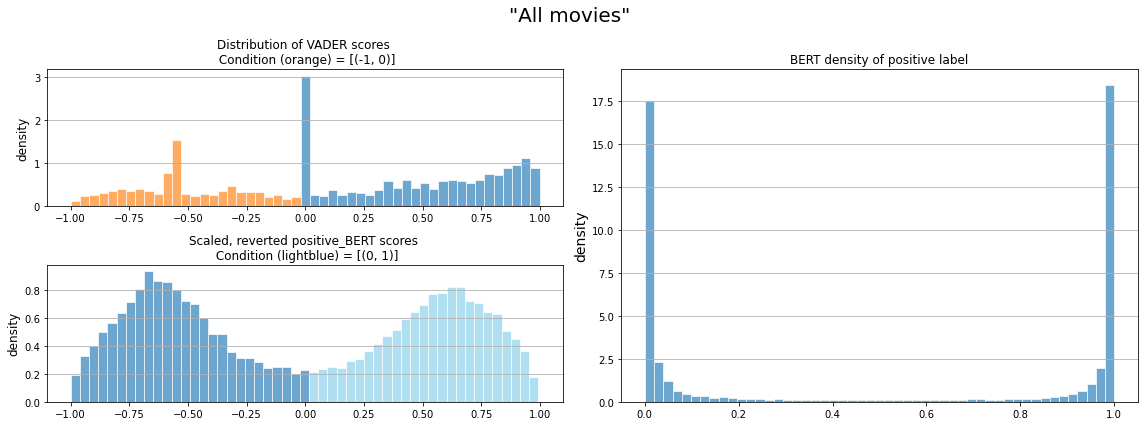

Analyzing 5 randomly chosen quotes given that satisfy following conditions. 
Conditions: VADER = (-1, 0), positive_BERT = (0.5, 1)

Quote w. index 37172:
 Post mortem report establishes a firearm injury from a bullet on the left side of the chin, viscera of the victim has preserved. Thorough investigation is being conducted to establish the sequence of events, added Anand Kumar. Deceased Vivek Tiwari's uncle, Tilakraj Tiwari, who had served as a police inspector, said,

Quote w. index 11949:
 touchstones were `Saturday Night Fever' and `Star Wars.

Quote w. index 58153:
 I was disheartened after Endgame because I wasn't ready to accept the fact that Iron Man is actually dead. And I thought it might be the end of all MCU movies after Spiderman: Far From Home. But, soon, the news hit me and now I cannot wait till next year to witness the new Marvel Phase Four.

Quote w. index 13093:
 The Nashville FC crest features the blue and gold colors of the Metro Nashville city seal with the overal

In [33]:
# The conditional attribute can eventually be changed to the df.sentiment_AFINN or any other attribute with same data structure
plotWithCondition(df, conditional_attribute="VADER", second_attribute="positive_BERT",
                  cond_bound=(-1,0), BERT_bound=(0,1))

printConditionQuotes(df, first_attribute="VADER",
                     second_attribute="positive_BERT", 
                     N=5, first_bound=(-1, 0), second_bound=(0.5, 1))

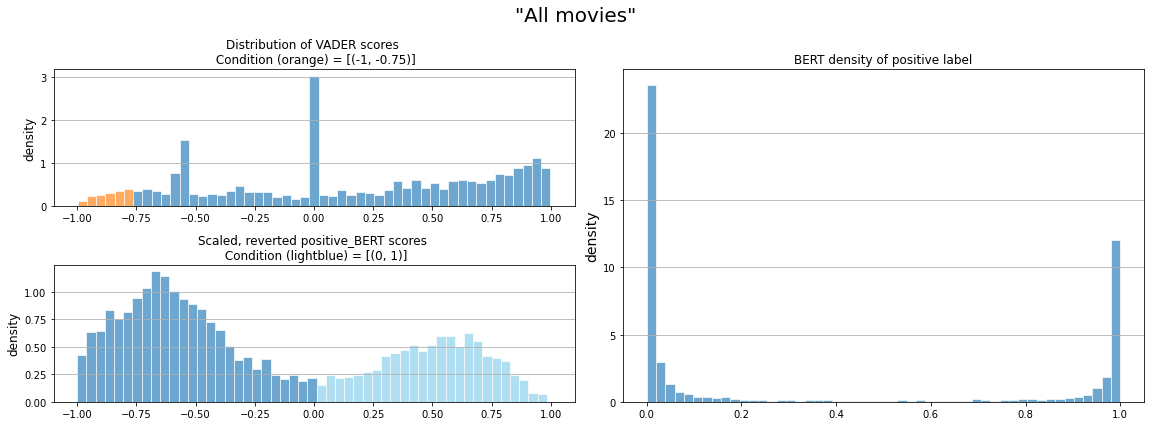

Analyzing 5 randomly chosen quotes given that satisfy following conditions. 
Conditions: VADER = (-1, -0.75), positive_BERT = (0.5, 1)

Quote w. index 56106:
 In the years since Avengers: Infinity War and Avengers: Endgame, [... ] two questions I've been asked: Is Loki really dead and what is Loki doing with that cube? It's always the cubes. This series will answer both of the questions.

Quote w. index 59609:
 As though we cannot love them both; mother and child. Is this Hollywood angst the same argument of Thanos, the bad guy from the last two Avengers Movies; that half the world needs to be destroyed? I guess Hollywood is telling us they are the bad guys and they know it, but it is worth it. - Is that the movies imitating life or vice versa?

Quote w. index 65149:
 I've never seen any Star Wars (films), and I kind of don't watch it now just because it infuriates people so much. They're like, `How?! How have you never watched any Star Wars?!' And now, I just want to see how long I ca

In [34]:
# The conditional attribute can eventually be changed to the df.sentiment_AFINN or any other attribute with same data structure
plotWithCondition(df, conditional_attribute="VADER", second_attribute="positive_BERT",
                  cond_bound=(-1,-0.75), BERT_bound=(0,1))

printConditionQuotes(df, first_attribute="VADER",
                     second_attribute="positive_BERT", 
                     N=5, first_bound=(-1, -0.75), second_bound=(0.5, 1))

**Comments:**
From the first of the two conditionings above we see that the BERT score are labelled negative almost as frequently as positive when looking at all quotes classified as negative by VADER (VADER score below 0). So the two approaches disagree on half of the labels classified as negative by VADER. From the second conditioning we see that this tendency reduces when looking at the strongly negative quotes classified by VADER where the BERT distribution gets more negative as well but still labels a large amount of the (negative by VADER) quotes as positive.

From the randomly chosen quotes we realize that Star Wars or in general the word "War" occur a lot in the quotes - especially for the strongly negative quotes. We will get back to this later.

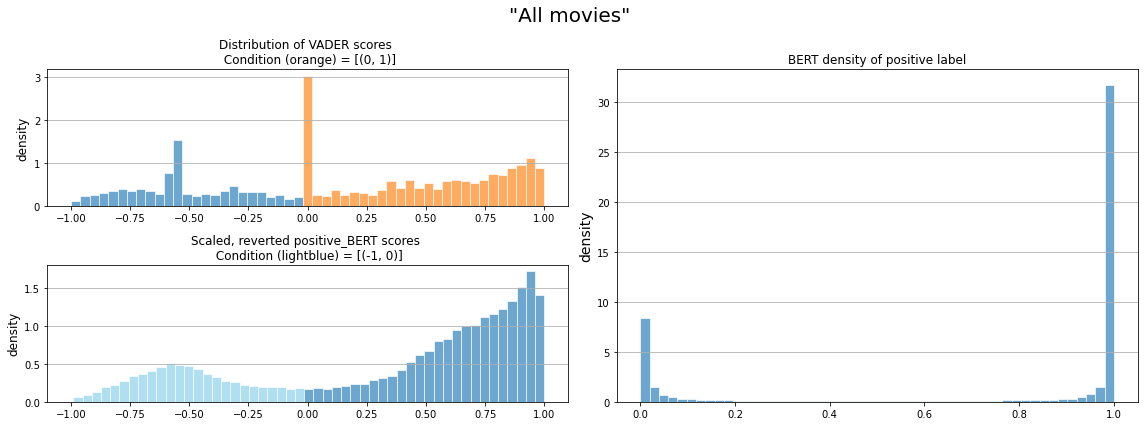

Analyzing 5 randomly chosen quotes given that satisfy following conditions. 
Conditions: VADER = (0, 1), positive_BERT = (0, 0.5)

Quote w. index 61999:
 On the other hand, if Toy Story 4 doesn't tarnish the series, it doesn't polish it either,

Quote w. index 67960:
 About seven years ago I got a Mark Twain award and Tracy was trying to do something about a guy who goes back to Africa to marry a girl just like I did in `Coming to America.' Then I got a better idea and the guy who directed `Black Panther,' Ryan Coogler, was interested and pitched a sequel. I thought, `Maybe I should try and get something together' .

Quote w. index 22612:
 I would love to see Roland on the beach with those lobster monstrosities. I understand the rationale behind the movie that is PG-13. I was totally signed off on that. I want as many people in the tent as possible, for all kinds of reasons. Part of it has to do with the dynamic between the Gunslinger and the boy. That's a father-son relationship. But 

In [35]:
# The conditional attribute can eventually be changed to the df.sentiment_AFINN or any other attribute with same data structure
plotWithCondition(df, conditional_attribute="VADER", second_attribute="positive_BERT",
                  cond_bound=(0,1), BERT_bound=(-1,0))

printConditionQuotes(df, first_attribute="VADER",
                     second_attribute="positive_BERT", 
                     N=5, first_bound=(0, 1), second_bound=(0, 0.5))

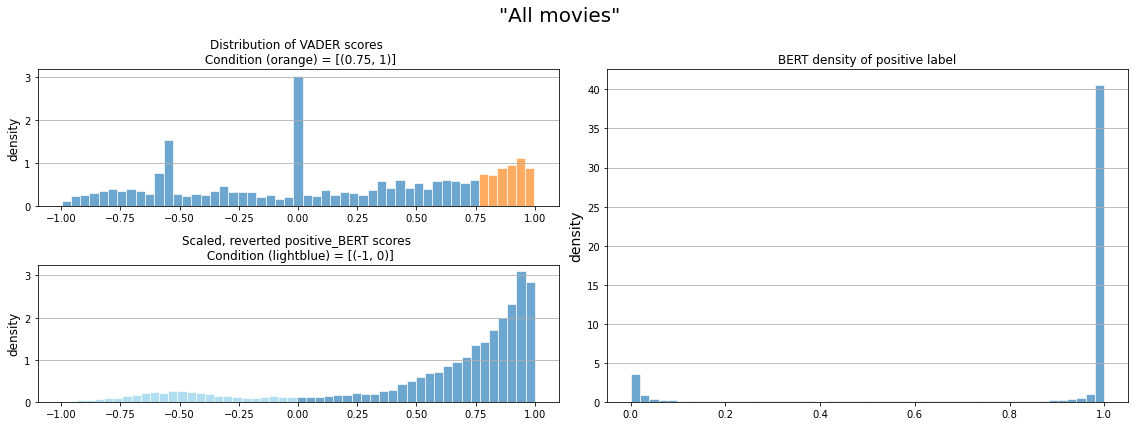

Analyzing 5 randomly chosen quotes given that satisfy following conditions. 
Conditions: VADER = (0.75, 1), positive_BERT = (0, 0.5)

Quote w. index 21049:
 How do you tell that story and get the audience comfortable with superpowered people in the real world? Do we want to start out with young heroes? And I think the answer was, let's see whether or not we can get the adult heroes up, before we go into the young world. So it was really about a year ago that we started looking at the landscape [ for bringing in Runaways ]. Some of that was about knowing that Spider-Man Homecoming was going to come out and he's a young hero, and some of it was there are networks out there that do cater to a younger audience. How do we get into business with them? How do we tell the best story that we could?

Quote w. index 67889:
 He really seemed like the next logical choice, but the challenge was how to update the Mysterio from the source material, the comics, into someone that we would see in the MCU

In [36]:
# The conditional attribute can eventually be changed to the df.sentiment_AFINN or any other attribute with same data structure
plotWithCondition(df, conditional_attribute="VADER", second_attribute="positive_BERT",
                  cond_bound=(0.75,1), BERT_bound=(-1,0))

printConditionQuotes(df, first_attribute="VADER",
                     second_attribute="positive_BERT", 
                     N=5, first_bound=(0.75, 1), second_bound=(0, 0.5))

**Comments:** 
On the other hand the tendency is remarkably different when conditioning on the positively labelling by VADER of the scores. For positively labelled quotes by VADER, BERT generally agrees but labels a small amount of quotes as negative. However, when VADER predicts quotes strongly positive, almost all of the BERT predicitons are positive too.

With regards to the random outputted examples it seems like "War" doesn't occur as much and that the quotes are in general longer than the mistakes when conditioning with negative VADER predicions. However, we are aware that the randomly outputted 5 quotes are not representative for all of the disagreeing labelled quotes.

We will now look at the representation of the movies when checking the above conditions to investigate whether there is a trend between the disagreeing of the labelling of quotes and the movies they concern. The following function is used for analyzing this through horizontal bar plots.

In [37]:
def barplotWithCondition(df, VADER_bounds, BERT_bounds):

    posBERT_scores = df['positive_BERT_score'] # pd.Series([score_dict[0]['score'] for score_dict in df["positive_BERT"]])
    VADER_scores = df['VADER_score'] #pd.Series([score_dict[0]['score'] for score_dict in df["sentiment_VADER"]])
    VADER_statement = np.logical_and(VADER_scores > VADER_bounds[0], VADER_scores < VADER_bounds[1])
    BERT_statement = np.logical_and(posBERT_scores > BERT_bounds[0], posBERT_scores < BERT_bounds[1])

    condition = np.logical_and(VADER_statement, BERT_statement)

    title, count = np.unique(df.movie[condition], return_counts=True)
    count, title = np.array(list(zip(*sorted(zip(count, title), reverse=False))))
    count = np.array([int(number) for number in count])

    plt.figure(figsize=(16,10))
    plt.title(f"Quotes about movies \n VADER condition: {VADER_bounds}, BERT condition: {BERT_bounds}", fontsize=20)
    plt.xlabel("count", fontsize=12)
    plt.barh(title, count, alpha=0.65)
    plt.grid(True, axis='x')
    plt.tight_layout()
    plt.show()

We start by visualizing the unconditioned distribution of movies to have as a comparison.

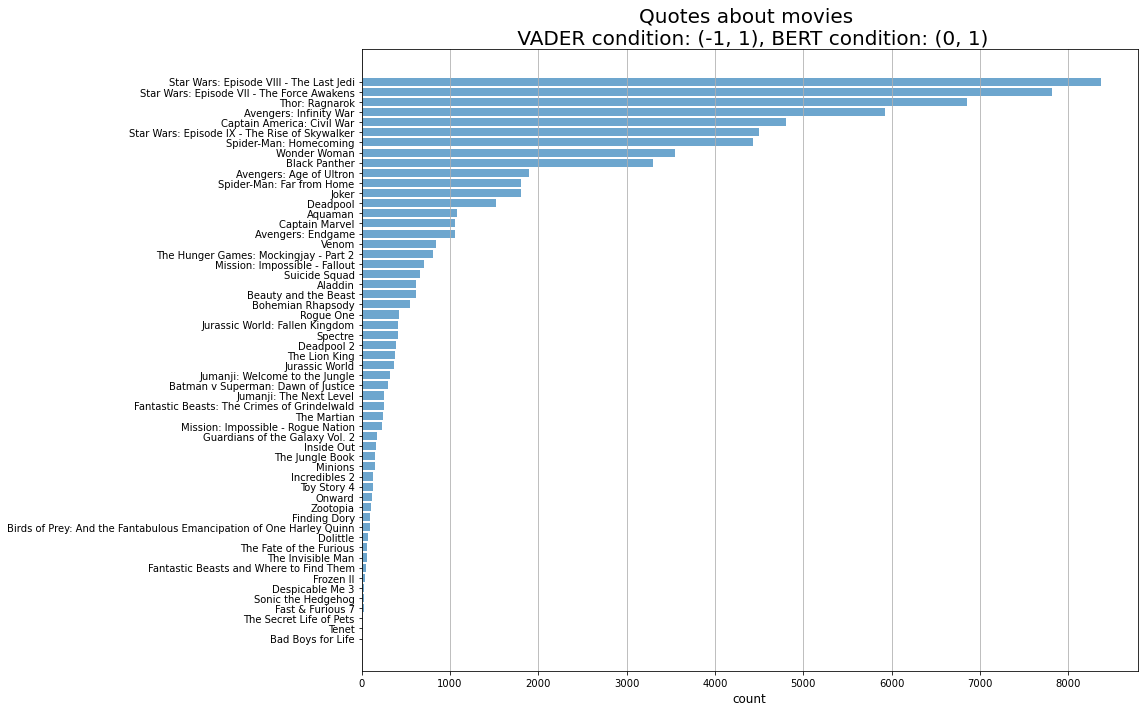

In [38]:
barplotWithCondition(df, VADER_bounds=(-1, 1), BERT_bounds=(0, 1))

Then we do the investigation with the same condition as in the previous investigation where we first look at the negatively labelled VADER predictions.

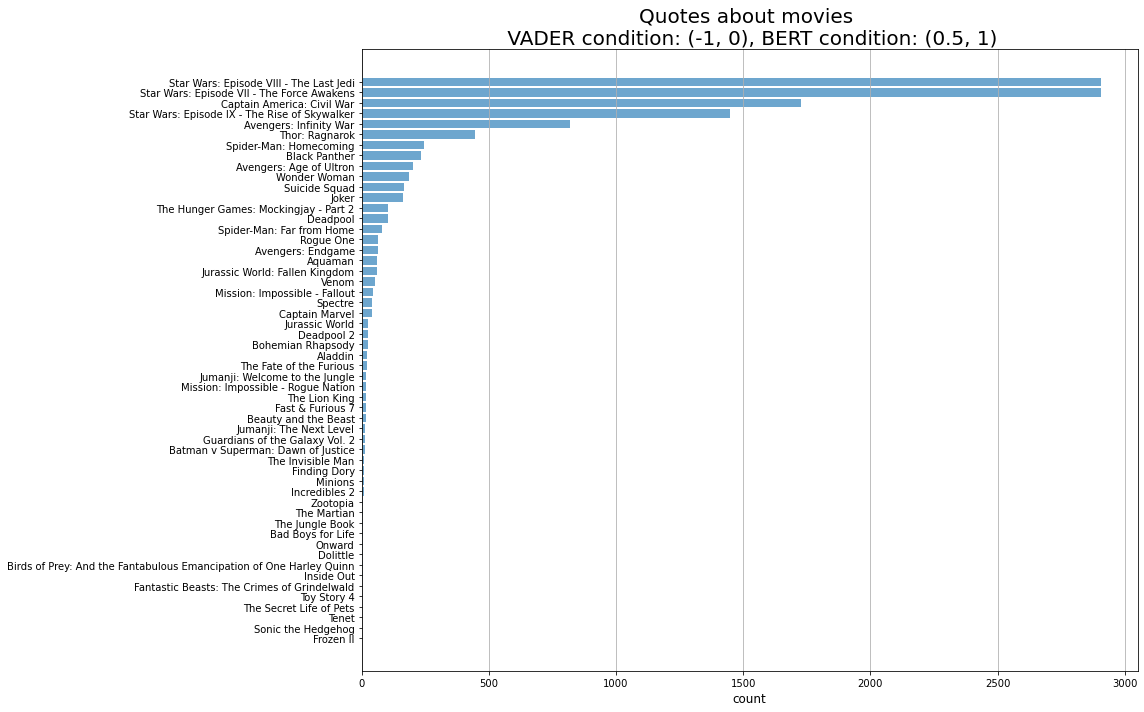

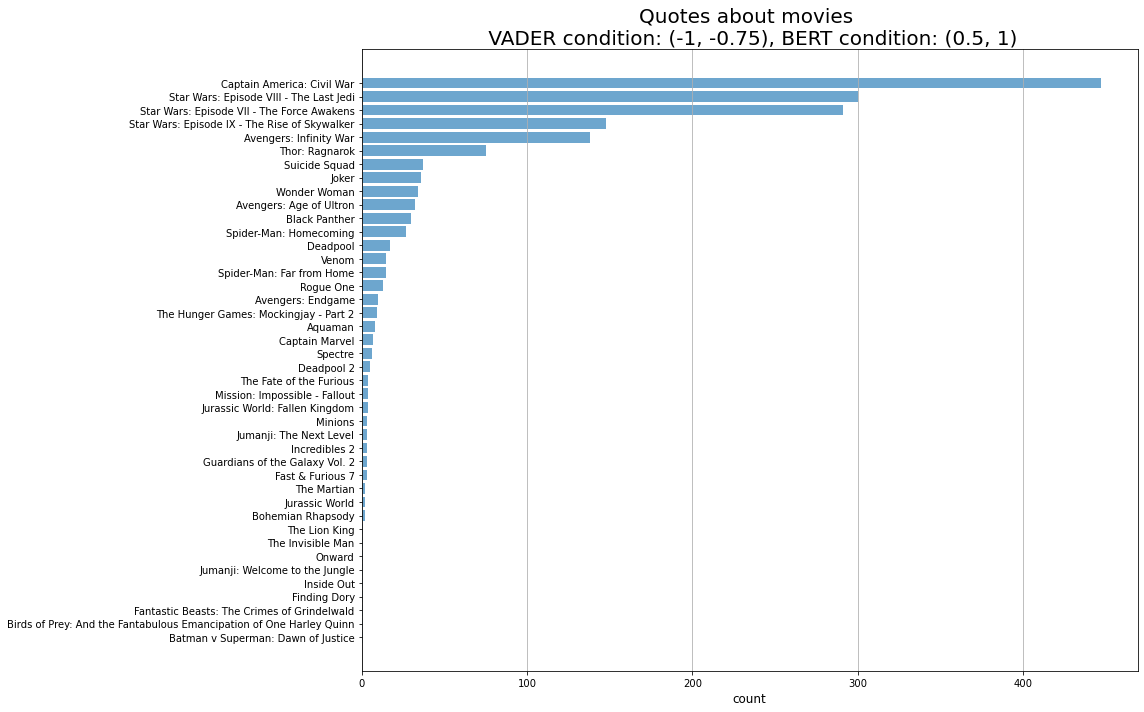

In [39]:
barplotWithCondition(df, VADER_bounds=(-1, 0), BERT_bounds=(0.5, 1))
barplotWithCondition(df, VADER_bounds=(-1, -0.75), BERT_bounds=(0.5, 1))

Even though Star Wars and other movie titles that have a negative title are quite highly represented without conditioning on the data it still seems like conditioning on negative VADER labels exagerates this tendency. Also it seems like the above plot (conditioning on negative VADER) kind of ranks the scores from most negatively to most positively associated movie title. In other words negative VADER labels that are positively labelled by the transformer in general concern movies with negative titles. Even though this tendency sounds like a good feature of the VADER approach we do not prefer this to the BERT as we do not want the sentiment score to reflect the sentiment of the movie title but rather the context in which it appears.

As we see below, there is not the same tendency for the disagreeing labelling when conditioning on positive VADER labels - it ressembles the original distribution more even though it is hard to say as we have a lot fewer data points with this conditioning.

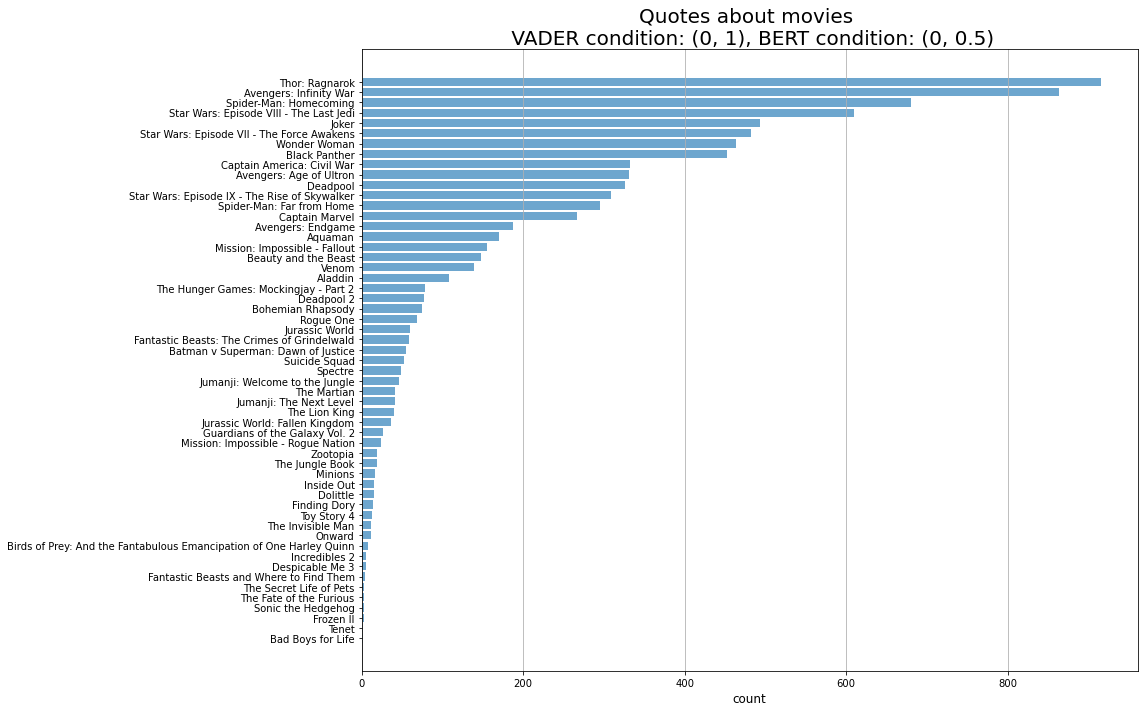

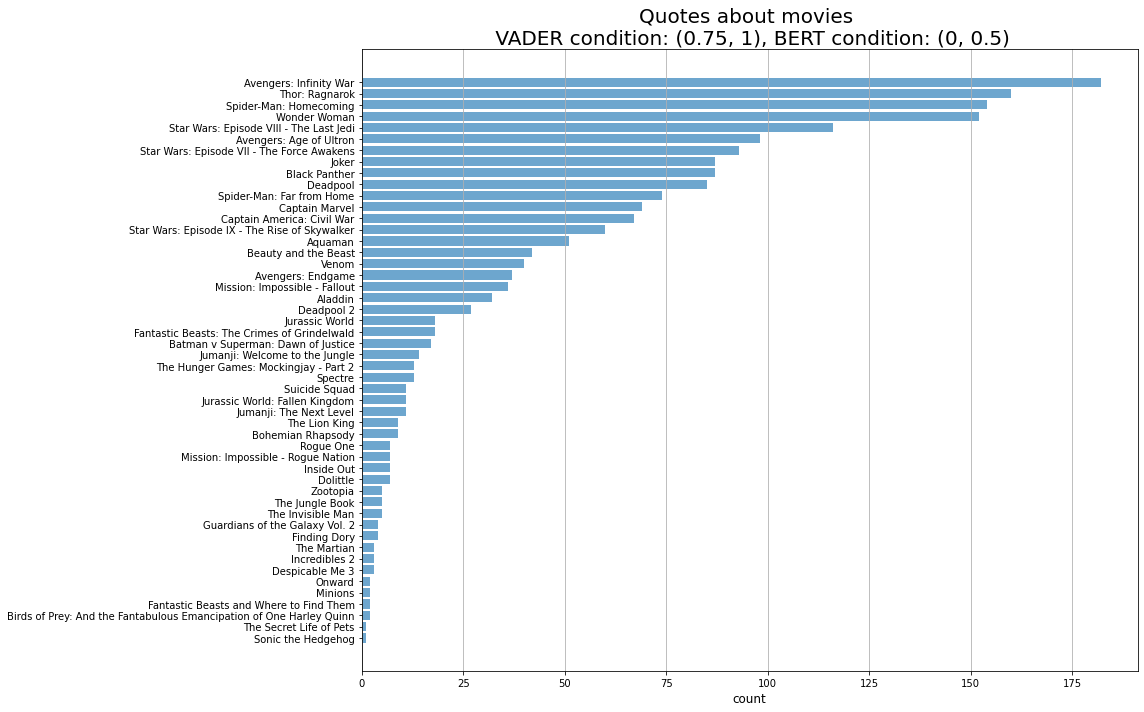

In [40]:
barplotWithCondition(df, VADER_bounds=(0, 1), BERT_bounds=(0, 0.5))
barplotWithCondition(df, VADER_bounds=(0.75, 1), BERT_bounds=(0, 0.5))

### Discussion and comments on different sentiment scores

Both approaches have pros and cons - here is a summary of them and an evaluation of which approach will be used as the main one for the future investigations.

VADER seems to struggle with interpreting larger semantical structures in the sentence compared to the transformer based labelling which was seen through conditioning plots of score and movie title distributions and the qualitative analysis of quotes that has different labels with the two approaches. This conclusion is based on the fact that strongly negative scores from the VADER approach are labelled almost equally much as positive or negative with the BERT transformer approach. Through further conditioning investigations we saw that the quotes causing a difference in labelling between the two approaches tend to concern specific movies or the length of the quote (depending on whether positive or negative conditions were used). For instance, it seems like the thing that causes BERT to label many of the quotes labelled as strongly negative by VADER is that VADER does not catch the semanticly neutral sentiment of the word "War" when "War" is part of a movie title where BERT does not associate a negative sentiment with this. 

On the other hand, BERT predicts using the probability outcome of a softmax function and is in general very certain about its predictions. This mean that it does not make sense to infer a neutral sentiment assignment with this pretrained BERT transformer which is definetely a con of the transformer approach as not all quotes need to be associated with EITHER a positive or a negative score.

Anyhow, we choose to continue with the transformer-based approach as it - as seen from initial analyses - is able to capture a more valid semantical understanding of quotes, which we weigh higher than the ability to do a neutral classification. We will however keep both but prioritize the BERT for further analyses. 

### AD(A)itional feature

Also applicable on the movie level - for instance we can analyze the same trends on the Top 2 most quoted movies.

In [41]:
title, count = np.unique(df.movie, return_counts=True)
count_sorted, title = np.array(list(zip(*sorted(zip(count, title), reverse=True))))

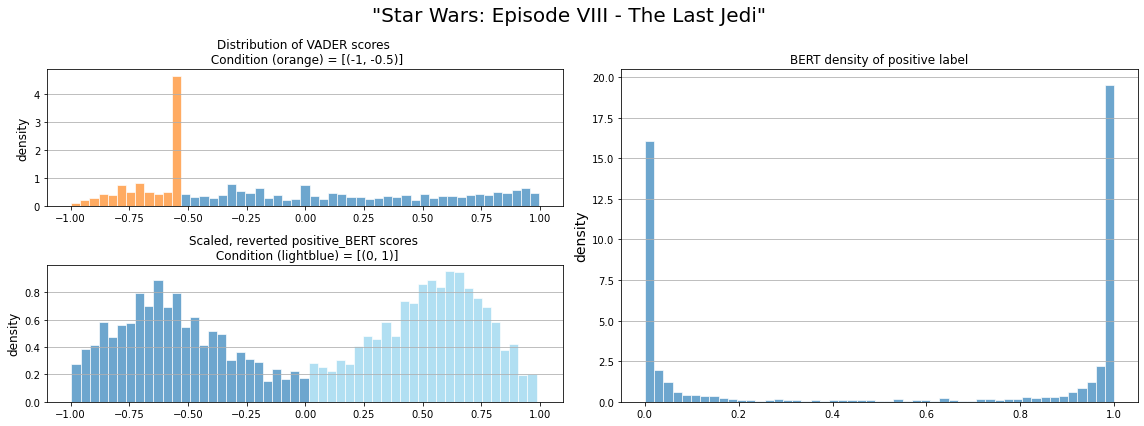

Analyzing 5 randomly chosen quotes given that satisfy following conditions. 
Conditions: VADER = (-1, 0.75), positive_BERT = (0.5, 1)

Quote w. index 22952:
 I think we should somehow incorporate Star Wars. I think that, you know, Adam and Eddy are huge Star Wars fans and if there was a way to bring Darth Vader in, then that would be cool. I think he would be a better love interest for the Evil Queen, but now that she's taken, but it would be fun to battle him.

Quote w. index 15836:
 `Star Wars' gives us a metaphor. It's a message tool involving serious shoppers.

Quote w. index 41603:
 Star Wars: The Jedi Path

Quote w. index 24316:
 All around us, dreamers were dreaming up new ideas: `Star Wars,' The Clash, Apple. I was nearing thirty fast and wanted to do something new, too.

Quote w. index 33238:
 I would like to introduce the Star Wars vegetable carving which I had created for my friends and myself. I've been making Star Wars vegetable carving over eleven years. It is the meeting

In [42]:
# The conditional attribute can eventually be changed to the df.sentiment_AFINN or any other attribute with same data structure
plotWithCondition(df, conditional_attribute="VADER", second_attribute="positive_BERT",
                  cond_bound=(-1,-0.5), BERT_bound=(0,1), 
                  movie=title[0])

printConditionQuotes(df, first_attribute="VADER",
                     second_attribute="positive_BERT", 
                     N=5, first_bound=(-1, 0.75), second_bound=(0.5, 1),
                     movie=title[0])

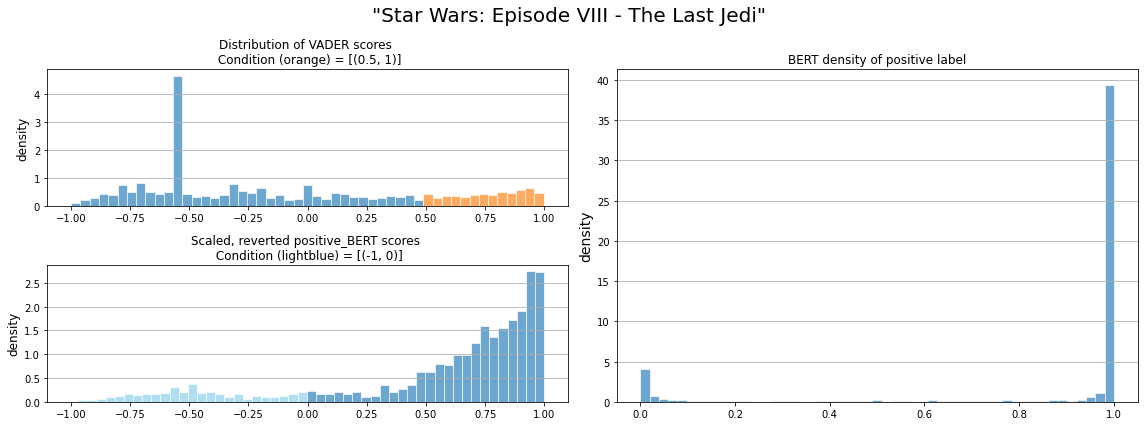

Analyzing 5 randomly chosen quotes given that satisfy following conditions. 
Conditions: VADER = (0.5, 1), positive_BERT = (0, 0.5)

Quote w. index 37004:
 Our customers are going twice as often as they did before. More importantly, the films they're going to are the small films that have lots of empty seats. They're not using it to go to `Star Wars.' More often you're going to see `Lady Bird' and `Greatest Showman' and all those films that really need a boost.

Quote w. index 35004:
 I thought The Last Jedi was brilliant, the first Star Wars movie since The Empire Strikes Back I thought was a complete success on its own terms. Then I thought Solo was perfectly adequate and inoffensive, and as much as I love Star Wars, that's a little sad. So for advice? Get the creative team behind The Last Jedi on your Fett movie, rather than the team behind Solo.

Quote w. index 41186:
 I'm not doing anything Star Wars, and, who knows what the future may hold, but that project is on the shelf now. T

In [43]:
# The conditional attribute can eventually be changed to the df.sentiment_AFINN or any other attribute with same data structure
plotWithCondition(df, conditional_attribute="VADER", second_attribute="positive_BERT",
                  cond_bound=(0.5,1), BERT_bound=(-1,0), 
                  movie=title[0])

printConditionQuotes(df, first_attribute="VADER",
                     second_attribute="positive_BERT", 
                     N=5, first_bound=(0.5, 1), second_bound=(0, 0.5),
                     movie=title[0])

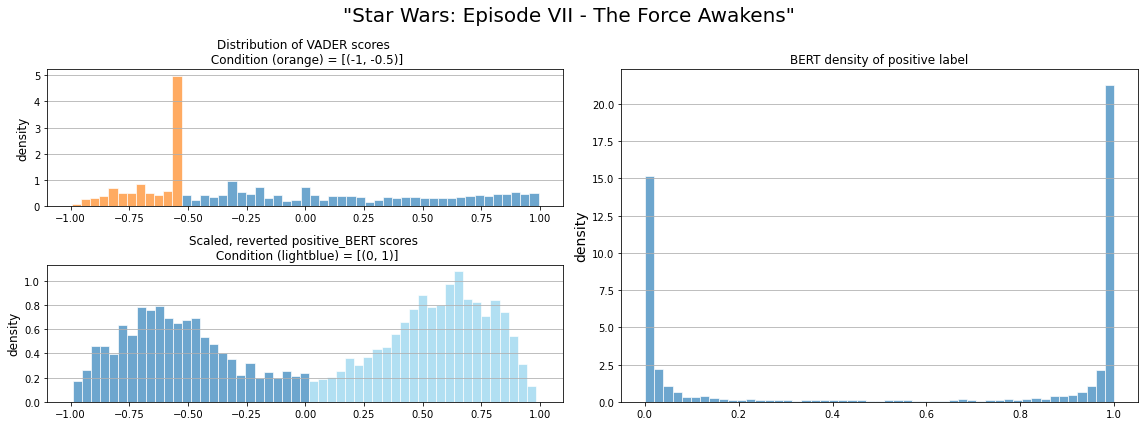

Analyzing 5 randomly chosen quotes given that satisfy following conditions. 
Conditions: VADER = (-1, 0.75), positive_BERT = (0.5, 1)

Quote w. index 5692:
 Don't miss the big kickoff for Star Wars Celebration Anaheim. Star Wars: The Force Awakens Writer/Director/Producer J.J. Abrams and Producer Kathleen Kennedy will be on the Celebration Stage, joined by special guests. This panel is scheduled to be simulcast to the Digital Stage from the Celebration Stage.

Quote w. index 11643:
 Let me help you out with this one, this show has absolutely nothing to do with Star Wars. It's just George Lucas describing everyday things.

Quote w. index 2260:
 Well, Star Wars was always about, you know -- it was always a boys' thing and a movie that dads take their sons to. And though that's still very much the case, I was really hoping that this could be a movie that mothers could take their daughters to, as well. So I'm looking forward to kids seeing this movie and seeing themselves in it.

Quote w. 

In [44]:
# The conditional attribute can eventually be changed to the df.sentiment_AFINN or any other attribute with same data structure
plotWithCondition(df, conditional_attribute="VADER", second_attribute="positive_BERT",
                  cond_bound=(-1,-0.5), BERT_bound=(0,1), 
                  movie=title[1])

printConditionQuotes(df, first_attribute="VADER",
                     second_attribute="positive_BERT", 
                     N=5, first_bound=(-1, 0.75), second_bound=(0.5, 1),
                     movie=title[1])

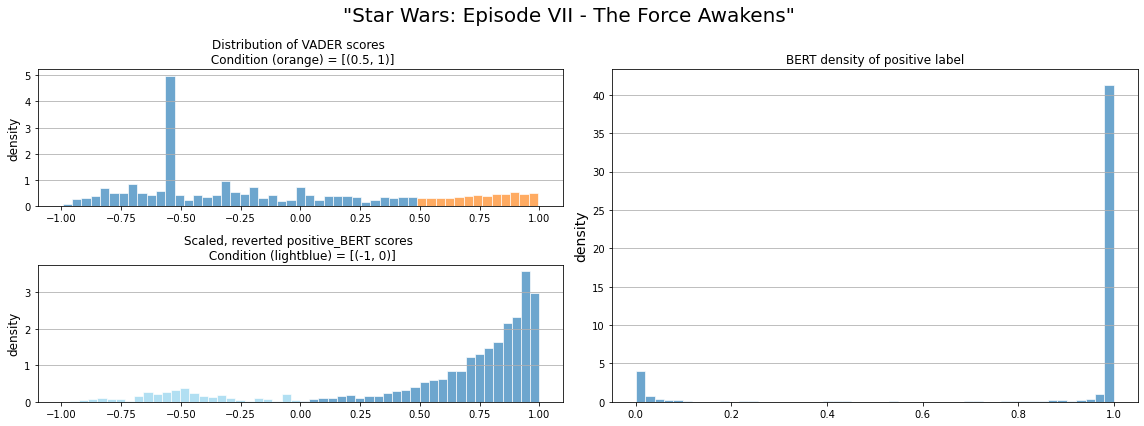

Analyzing 5 randomly chosen quotes given that satisfy following conditions. 
Conditions: VADER = (0.5, 1), positive_BERT = (0, 0.5)

Quote w. index 2441:
 To give `The Force Awakens' its best chance for proving itself to me, I've avoided every spoiler and every board speculating about the film's story,

Quote w. index 7822:
 With Disney's focus on big animated offerings, comic book adventures, and `Star Wars' spin-offs, the kinds of adult-oriented, smaller pictures that DreamWorks made in recent years, such as `The Help' and `Lincoln,' often seemed like an awkward fit and a case of competing sensibilities,

Quote w. index 12585:
 We are planning to sit down in January, since we will have had The Force Awakens released, now Rogue One, and we've finished shooting Episode VIII. We have enough information where we can step back a little bit and say, What are we doing? What do we feel is exciting? And what are some of the things we want to explore?

Quote w. index 3633:
 Darth Vader is my f

In [45]:
# The conditional attribute can eventually be changed to the df.sentiment_AFINN or any other attribute with same data structure
plotWithCondition(df, conditional_attribute="VADER", second_attribute="positive_BERT",
                  cond_bound=(0.5,1), BERT_bound=(-1,0), 
                  movie=title[1])

printConditionQuotes(df, first_attribute="VADER",
                     second_attribute="positive_BERT", 
                     N=5, first_bound=(0.5, 1), second_bound=(0, 0.5),
                     movie=title[1])

Having created the sentiment score in preprocessing, we now just check for the two quotes with minimum (i.e. most negative) and maximum (i.e. most positive) sentiment according to the VADER and BERT sentiment lexicon. 

In [46]:
print("Quote with minimum VADER sentiment:\n")
print(df.loc[VADER_scores.argmin()].quotation)

Quote with minimum VADER sentiment:

Red Five' article in issues 123, 124, 146, 152, 161, or 162. Issues Edit Star Wars Insider 118 -- Dave Filoni Star Wars Insider 119 -- Kyle Newman and Jaime King Star Wars Insider 120 -- John Jackson Miller Star Wars Insider 121 -- John Hudgens Star Wars Insider 122 -- Paul S. Kemp Star Wars Insider 125 -- David Acord Star Wars Insider 126 -- Steve Sansweet Star Wars Insider 127 -- Joel Aron Star Wars Insider 128 -- Timothy Zahn Star Wars Insider 129 -- Mark Hamill Star Wars Insider 130 -- Mark Kermode Star Wars Insider 131 -- Nick Gillard Star Wars Insider 132 -- Ashley Eckstein Star Wars Insider 133 -- Danny Wagner Star Wars Insider 134 -- James Burns and Dan Curto Star Wars Insider 135 -- Robert Watts Star Wars Insider 136 -- Randy Martinez Star Wars Insider 137 -- Joe Corroney Star Wars Insider 138 -- Catherine Taber Star Wars Insider 139 -- Jason Fry Star Wars Insider 140 -- Jeremy Bulloch Star Wars Insider 141 -- Don Bies Star Wars Insider 142

In [47]:
print("Quote with maximum VADER sentiment:\n")
print(df.loc[VADER_scores.argmax()].quotation)

Quote with maximum VADER sentiment:

Starring in Avengers: Infinity War is BAFTA Award nominee Chris Hemsworth as Thor, Academy Award nominee Josh Brolin as Thanos, Saturn Award Winner Chris Pratt as Star Lord / Peter Quill, Teen Choice Awards nominee Sebastian Stan as Bucky, four-time Golden Globe Award nominee Scarlett Johansson as Natasha Romanoff / Black Widow, Academy Award nominee Benedict Cumberbatch as Dr. Stephen Strange, Academy Award winner Brie Larson as Carol Danvers / Captain Marvel, ALMA Award winner Zoe Saldana as Gamora, Empire Award winner Karen Gillan as Nebula, two-time Academy Award nominee Jeremy Renner as Clint Barton / Hawkeye, two-time Saturn Award nominee Chris Evans as Steve Rogers / Captain America, BAFTA Awards nominee Elizabeth Olsen as Wanda Maximoff / Scarlet, four-time Academy Award nominee Bradley Cooper as Rocket Raccoon, Screen Actors Guild Awards nominee Vin Diesel as Groot, Academy Award nominee Samuel L. Jackson as Nick Fury, Screen Actors Guild A

In [48]:
print("Quote with minimum BERT sentiment:\n")
print(df.loc[posBERT_scores.argmin()].quotation)

Quote with minimum BERT sentiment:

Suicide Squad is just bad. It's ugly and boring, a toxic combination that means the film's highly fetishized violence doesn't even have the exciting tingle of the wicked or the taboo.


In [49]:
print("Quote with maximuma BERT sentiment:\n")
print(df.loc[posBERT_scores.argmax()].quotation)

Quote with maximuma BERT sentiment:

To work on Fantastic Beasts is a wonderful musical opportunity,


If we were to only base our conclusions on these most extreme quotes, we would also definitely choose BERT as it seems way more valid and since it seems to capture the essence of the sentence and is not affected as the size of the quote as much as VADER - even though VADER should be normalized when reading the documentation. This is another good reason for mainly using the BERT approach.